In [1]:
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pymc3 as pm
import seaborn as sns


az.style.use('arviz-darkgrid')

In [2]:
WAFFLE_DATA = 'waffle_divorce.csv'
DATA_FOLDER = '../../data'

In [3]:
df_waf = pd.read_csv(f'{DATA_FOLDER}/{WAFFLE_DATA}')
df_waf.head()

,Unnamed: 0,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage.SE,Divorce,Divorce.SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860
0,1,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45
1,2,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00
2,3,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00
3,4,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26
4,5,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00


In [4]:
df_waf['age_stan'] = (df_waf['MedianAgeMarriage'] - df_waf['MedianAgeMarriage'].mean()) / df_waf['MedianAgeMarriage'].std()
df_waf['divorce_stan'] = (df_waf['Divorce'] - df_waf['Divorce'].mean()) / df_waf['Divorce'].std()
df_waf['marriage_stan'] = (df_waf['Marriage'] - df_waf['Marriage'].mean()) /df_waf['Marriage'].std()

## Predictor Residual Plots

$$
\begin{align*}
    M_i     & \sim N(\mu_i, \sigma) \\
    \mu_i   & \sim \alpha + \beta_A \cdot A_i\\
    \alpha  & \sim N(0, 0.2) \\
    \beta_A & \sim N(0, 0.5) \\
    \sigma  & \sim \text{Exponential}(1)
\end{align*}
$$

### Code 5.13

In [5]:
with pm.Model() as m_5_4:
    alpha = pm.Normal('alpha', mu=0.0, sigma=0.2)
    beta_A = pm.Normal('beta_A', mu=0.0, sigma=0.5)
    sigma = pm.Exponential('sigma', lam=1.0)
    
    mu = pm.Deterministic('mu', alpha + beta_A * df_waf['age_stan'])
    M = pm.Normal('marriage', mu=mu, sigma=sigma, observed=df_waf['marriage_stan'])
    
    trace_5_4 = pm.sample(5000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_A, alpha]


Sampling 4 chains for 2_000 tune and 5_000 draw iterations (8_000 + 20_000 draws total) took 7 seconds.


In [6]:
df_tr_5_4 = pm.trace_to_dataframe(trace_5_4)
df_tr_5_4.head()

,alpha,beta_A,sigma,mu__0,mu__1,mu__2,mu__3,mu__4,mu__5,mu__6,...,mu__40,mu__41,mu__42,mu__43,mu__44,mu__45,mu__46,mu__47,mu__48,mu__49
0,-0.015523,-0.780218,0.696536,0.457515,0.520253,0.143830,1.084887,-0.483542,0.206567,-0.985439,...,0.269304,0.520253,0.520253,1.712258,-0.546279,-0.232593,0.081093,0.645727,-0.169856,1.147624
1,0.040879,-0.558391,0.697380,0.379426,0.424326,0.154925,0.828427,-0.294075,0.199825,-0.653276,...,0.244726,0.424326,0.424326,1.277427,-0.338975,-0.114475,0.110025,0.514126,-0.069575,0.873327
2,0.040879,-0.558391,0.697380,0.379426,0.424326,0.154925,0.828427,-0.294075,0.199825,-0.653276,...,0.244726,0.424326,0.424326,1.277427,-0.338975,-0.114475,0.110025,0.514126,-0.069575,0.873327
3,0.014479,-0.683121,0.713206,0.428648,0.483578,0.154000,0.977945,-0.395296,0.208930,-0.834733,...,0.263860,0.483578,0.483578,1.527241,-0.450225,-0.175577,0.099071,0.593437,-0.120648,1.032874
4,0.011927,-0.716493,0.617002,0.446329,0.503942,0.158264,1.022459,-0.417865,0.215877,-0.878769,...,0.273490,0.503942,0.503942,1.598589,-0.475478,-0.187413,0.100651,0.619168,-0.129800,1.080072


In [7]:
df_mu_5_4 = df_tr_5_4.filter(regex='(mu.*)')
df_mu_5_4.head()

,mu__0,mu__1,mu__2,mu__3,mu__4,mu__5,mu__6,mu__7,mu__8,mu__9,...,mu__40,mu__41,mu__42,mu__43,mu__44,mu__45,mu__46,mu__47,mu__48,mu__49
0,0.457515,0.520253,0.143830,1.084887,-0.483542,0.206567,-0.985439,-0.358067,-2.302919,-0.232593,...,0.269304,0.520253,0.520253,1.712258,-0.546279,-0.232593,0.081093,0.645727,-0.169856,1.147624
1,0.379426,0.424326,0.154925,0.828427,-0.294075,0.199825,-0.653276,-0.204275,-1.596177,-0.114475,...,0.244726,0.424326,0.424326,1.277427,-0.338975,-0.114475,0.110025,0.514126,-0.069575,0.873327
2,0.379426,0.424326,0.154925,0.828427,-0.294075,0.199825,-0.653276,-0.204275,-1.596177,-0.114475,...,0.244726,0.424326,0.424326,1.277427,-0.338975,-0.114475,0.110025,0.514126,-0.069575,0.873327
3,0.428648,0.483578,0.154000,0.977945,-0.395296,0.208930,-0.834733,-0.285436,-1.988254,-0.175577,...,0.263860,0.483578,0.483578,1.527241,-0.450225,-0.175577,0.099071,0.593437,-0.120648,1.032874
4,0.446329,0.503942,0.158264,1.022459,-0.417865,0.215877,-0.878769,-0.302639,-2.088642,-0.187413,...,0.273490,0.503942,0.503942,1.598589,-0.475478,-0.187413,0.100651,0.619168,-0.129800,1.080072


In [8]:
mu_means_5_4 = df_mu_5_4.apply(np.mean, axis=0)

mu_means_5_4[:5]

mu__0    0.418943
mu__1    0.474636
mu__2    0.140476
mu__3    0.975878
mu__4   -0.416459
dtype: float64

In [9]:
residuals_marriage = df_waf['marriage_stan'].values - mu_means_5_4.values
residuals_marriage[:5]

array([-0.39629892,  1.07516515, -0.09150119,  0.67924499,  0.14947004])

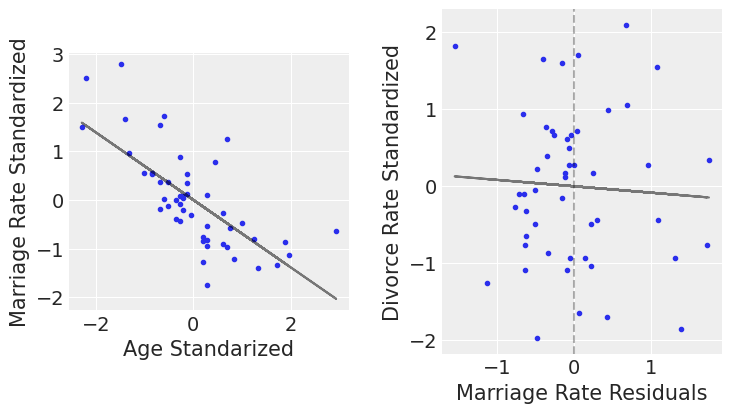

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.scatter(df_waf['age_stan'], df_waf['marriage_stan'], marker='.')
ax1.plot(df_waf['age_stan'], mu_means_5_4, 'k-', alpha=0.5)
ax1.set_xlabel('Age Standarized')
ax1.set_ylabel('Marriage Rate Standardized')
ax1.set_aspect('equal')

ax2.scatter(residuals_marriage, df_waf['divorce_stan'], marker='.')
ax2.set_xlabel('Marriage Rate Residuals')
ax2.set_ylabel('Divorce Rate Standardized')
ax2.set_aspect('equal')
ax2.axvline(x=0.0, ls='--', color='k', alpha=0.3)

m, c = np.polyfit(residuals_marriage, df_waf['divorce_stan'], deg=1)
fitted_line = [m * x + c for x in residuals_marriage]

ax2.plot(residuals_marriage, fitted_line, 'k-', alpha=0.5)

plt.show()